# Chapter 11

In [238]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import metakernel
import ipywidgets as widgets    
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import networkx as nx
import seaborn as sns
pastel_colors = sns.color_palette("pastel")
 

## Neural networks and computation

The idea is to view an algorithm as a flowchart which takes you from some inputs to an output, via a series of intermediate steps in which you combine elements from the previous steps; and further the intermediate steps can act in parallel.

This is presumably familiar from everyday activities like baking a cake:

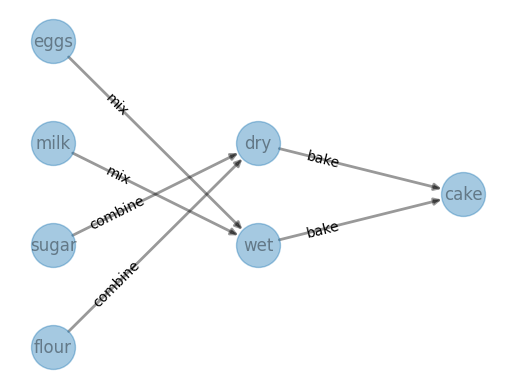

In [239]:
# Create a directed graph
G = nx.DiGraph()

G.add_node('milk', layer=0)
G.add_node('eggs', layer=0)

G.add_node('flour', layer=0)
G.add_node('sugar', layer=0)

G.add_node('wet', layer=1)
G.add_node('dry', layer=1)


G.add_node('cake', layer=2)

my_weight=2

G.add_edge('milk', 'wet', label = 'mix', weight =my_weight)
G.add_edge('eggs', 'wet', label = 'mix', weight =my_weight)

G.add_edge('flour', 'dry', label = 'combine', weight =my_weight)
G.add_edge('sugar', 'dry', label = 'combine', weight =my_weight)

G.add_edge('wet', 'cake', label = 'bake', weight =my_weight)
G.add_edge('dry', 'cake', label = 'bake', weight =my_weight)

weights = [G[u][v]['weight'] for u,v in G.edges()]


# Compute the layout and draw the graph
pos = nx.multipartite_layout(G, subset_key='layer')
nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'label'), label_pos=0.3)
nx.draw(G, pos, with_labels=True, node_size=1000, alpha=0.4, width=weights)

plt.show()

And one can view the order in which simple arithmetic functions as being given similarly by such a flowchart:

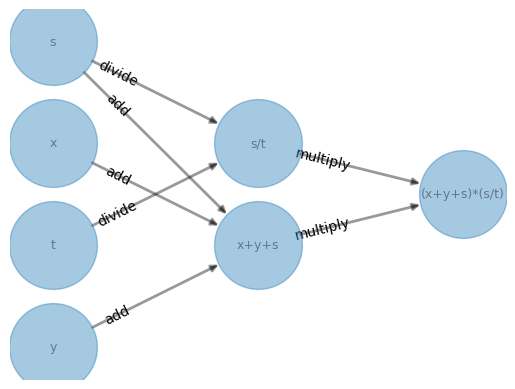

In [248]:
# Create a directed graph
G = nx.DiGraph()

G.add_node('x', layer=0)
G.add_node('y', layer=0)

G.add_node('s', layer=0)
G.add_node('t', layer=0)

G.add_node('x+y+s', layer=1)
G.add_node('s/t', layer=1)


G.add_node('(x+y+s)*(s/t)', layer=2)

my_weight=2

G.add_edge('x', 'x+y+s', label = 'add', weight =my_weight)
G.add_edge('y', 'x+y+s', label = 'add', weight =my_weight)
G.add_edge('s', 'x+y+s', label = 'add', weight =my_weight)

G.add_edge('s', 's/t', label = 'divide', weight =my_weight)
G.add_edge('t', 's/t', label = 'divide', weight =my_weight)

G.add_edge('x+y+s', '(x+y+s)*(s/t)', label = 'multiply', weight =my_weight)
G.add_edge('s/t', '(x+y+s)*(s/t)', label = 'multiply', weight =my_weight)


weights = [G[u][v]['weight'] for u,v in G.edges()]


# Compute the layout and draw the graph
pos = nx.multipartite_layout(G, subset_key='layer')
nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'label'), label_pos=0.3)
nx.draw(G, pos, with_labels=True, node_size=4000, alpha=0.4, width=weights, font_size=9)

plt.show()

If one wants to implement this idea in general, one needs to choose methods of 'combining elements' which are the appropriate mixture of:

- small in number: they are the building blocks and these need to be few in number
- computationally simple: they are the basic computational apparatus and need to be easy to compute
- expressively rich: when put together they need to be able to express lots of concepts



The traditional choice is to make methods of 'combining elements' be activation functions applied to linear functions, with a linear function at the very end.

Linear functions are by themselves very simple and computationally inexpensive. Ditto for activation functions. But when combined together these two things can expressively rich.

## Linear functions

### Definition

A *linear function* $f:\mathbb{R}^n\rightarrow \mathbb{R}$ is given by an equation of the form:

$$f(x_1,\ldots, x_n) = c_1\cdot x_1+\cdots c_n\cdot x_n+c$$

where the $c_1, \ldots, c_n, c$ are fixed real numbers, the coefficients. 

Geometrically, in the case of $n=1$, these are simple lines, in the case $n=2$ these are planes.

In [ ]:
def plot_2d_3d(c1, c2, d1, d2, d3):
    # Generate x and y values
    x = np.linspace(-10, 10, 400)
    y = np.linspace(-10, 10, 400)
    x1, y1 = np.meshgrid(x, y)

    # Calculate z1 and z2
    z1 = c1*x + c2
    z2 = d1*x1 + d2*y1 + d3

    # Create the plots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # 2D plot
    axs[0].plot(x, z1)
    axs[0].set_title('y = %1.2f*x + %1.2f' % (c1, c2))
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('z1')
    axs[0].set_xlim(-10, 10)
    axs[0].set_ylim(-10, 10)    

    # 3D plot
    axs[1] = fig.add_subplot(122, projection='3d')
    axs[1].plot_surface(x1, y1, z2, color='b')
    axs[1].set_title('y = %1.2f*x + %1.2f*y + %1.2f' % (d1, d2, d3))
    axs[1].set_xlim(-10, 10)
    axs[1].set_ylim(-10, 10)      
    axs[1].set_zlim(-10, 10)      

    plt.tight_layout()
    plt.show()

In [ ]:
interactive(plot_2d_3d, c1=FloatSlider(value=2, min=-10, max=10, step=0.1, description='c1:'),
                        c2=FloatSlider(value=3, min=-10, max=10, step=0.1, description='c2:'),
                        d1=FloatSlider(value=1, min=-10, max=10, step=0.1, description='d1:'),
                        d2=FloatSlider(value=-1, min=-10, max=10, step=0.1, description='d2:'),
                        d3=FloatSlider(value=2, min=-10, max=10, step=0.1, description='d3:'))

## Activation functions

An **activation function** is a function $a:\mathbb{R}\rightarrow \mathbb{R}$. 

In [ ]:
def perceptron(x):
    return np.where(x >= 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def siegelmann(x):
    return np.where(x < 0, 0, np.where(x <= 1, x, 1))


def relu(x):
    return np.maximum(0, x)

In [ ]:
# Generate x values
x = np.linspace(-10, 10, 1000)

# Calculate y values
y_perceptron = perceptron(x)
y_sigmoid = sigmoid(x)
y_siegelmann = siegelmann(x)
y_relu = relu(x)

# Create the plots
fig, axs = plt.subplots(2, 2, figsize=(10, 3))

# Perceptron plot
axs[0,0].plot(x, y_perceptron)
axs[0,0].set_title('Perceptron y = 1 if x≥0 else 0')
axs[0,0].set_xlim(-5, 5)
axs[0,0].set_ylim(-.05, 1.1)


# Sigmoid plot
axs[0,1].plot(x, y_sigmoid)
axs[0,1].set_title('Sigmoid y = 1 / (1 + exp(-x))')
axs[0,1].set_xlim(-5, 5)
axs[0,1].set_ylim(-.05, 1.1)

# Siegelmann plot
axs[1,0].plot(x, y_siegelmann)
axs[1,0].set_title('Sigma y = x if 0≤x≤1 else 0 if x<0 else 1')
axs[1,0].set_xlim(-5, 5)
axs[1,0].set_ylim(-.05, 1.1)


# ReLU plot
axs[1,1].plot(x, y_relu)
axs[1,1].set_title('ReLU y = max(0, x)')
axs[1,1].set_xlim(-5, 5)
axs[1,1].set_ylim(-.05, 1.1)


plt.tight_layout()
plt.show()

## Shallow neural networks

In [ ]:
def shallow(f, g, a1, b1, a2, b2, a3, b3, c1, c2, c3, d):
# Generate x values
    x = np.linspace(-10, 10, 100)

    # Calculate y values
    y1 = a1 * x + b1
    y2 = a2 * x + b2
    y3 = a3 * x + b3

    z1 = c1*f(y1) + c2*f(y2) + c3*f(y3)+d
    z2 = c1*g(y1) + c2*g(y2) + c3*g(y3)+d    

    # Create the plots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))    

    # Create the plot
    axs[0].plot(x, y1, color=pastel_colors[0], label ='y1 = a1*x + b1')
    axs[0].plot(x, y2, color=pastel_colors[1], label ='y2 = a2*x + b2')
    axs[0].plot(x, y3, color=pastel_colors[2], label ='y3 = a3*x + b3')
    axs[0].plot(x, z1, color = 'b', label ='y = c1*f(y1) + c2*f(y2) + c3*f(y3)+d')
    axs[0].set_xlim(-10, 10)
    axs[0].set_xlim(-10, 10)
    axs[0].legend(loc = 'upper left')   
    axs[0].set_title('f = %s' % f.__name__)

    # Create the plot
    axs[1].plot(x, y1, color=pastel_colors[0], label ='y1 = a1*x + b1')
    axs[1].plot(x, y2, color=pastel_colors[1], label ='y2 = a2*x + b2')
    axs[1].plot(x, y3, color=pastel_colors[2], label ='y3 = a3*x + b3')
    axs[1].plot(x, z2, color = 'b', label ='y = c1*g(y1) + c2*g(y2) + c3*g(y3)+d')
    axs[1].set_xlim(-10, 10)
    axs[1].set_xlim(-10, 10)
    axs[1].legend(loc = 'upper left')   
    axs[1].set_title('g = %s' % g.__name__)

    fig.suptitle('Example of a shallow neural network \n with 3 hidden units \n %s vs. %s' % (f.__name__, g.__name__), y=1.02)

    plt.show()


In [ ]:
shallow(sigmoid, relu, 1, 2, -1, 3, -1, 2, 1, 2, 3, -5)

In [ ]:
interactive(shallow,
                    f = fixed(sigmoid),
                    g = fixed(relu),
                    a1=FloatSlider(value=1, min=-10, max=10, step=0.1, description='a1:'),
                    b1=FloatSlider(value=2, min=-10, max=10, step=0.1, description='b1:'),
                    a2=FloatSlider(value=-1, min=-10, max=10, step=0.1, description='a2:'),
                    b2=FloatSlider(value=3, min=-10, max=10, step=0.1, description='b2:'),
                    a3=FloatSlider(value=-1, min=-10, max=10, step=0.1, description='a3:'),
                    b3=FloatSlider(value=2, min=-10, max=10, step=0.1, description='b3:'),
                    c1=FloatSlider(value=1, min=-10, max=10, step=0.1, description='c1:'),
                    c2=FloatSlider(value=2, min=-10, max=10, step=0.1, description='c2:'),
                    c3=FloatSlider(value=3, min=-10, max=10, step=0.1, description='c3:'),
                    d=FloatSlider(value=-5, min=-10, max=10, step=0.1, description='d:'))    

## Deep neural networks

## Recurrent neural networks